# Tiền xử lý dữ liệu dạng bảng - Preprocessing Tabular Data

## 1. Xử lý giá trị khuyết thiếu - Handling Missing Values


In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import math
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

RMSE Mean Imputation    : 148.2711
RMSE Forward Fill       : 225.2179
RMSE Backward Fill      : 204.5845


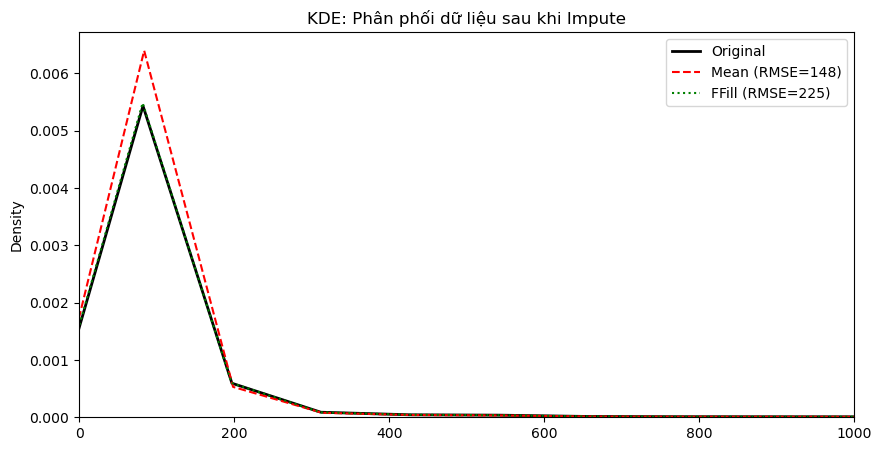

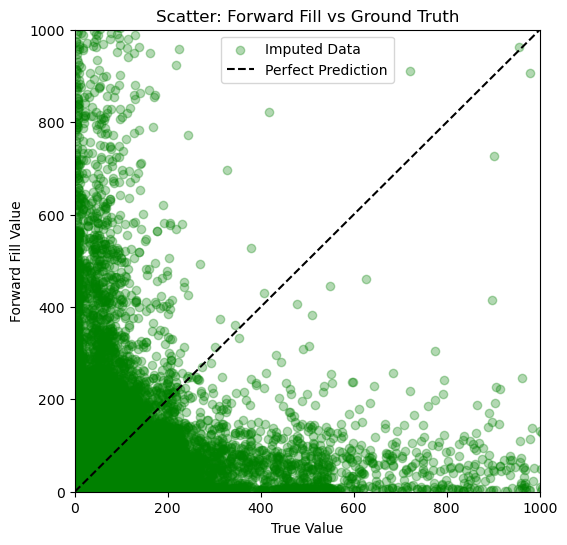

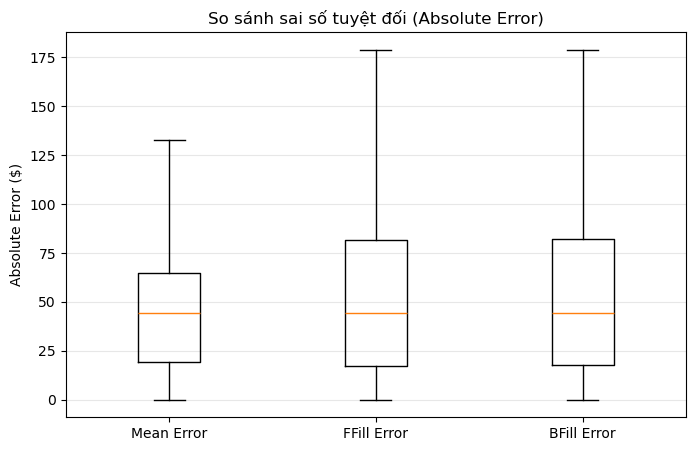

In [ ]:
# =========================
#        LOAD DATA
# =========================
dataTrain = pd.read_csv('../data/tabular/fraudTrain.csv')
dataTest  = pd.read_csv('../data/tabular/fraudTest.csv')

# Chỉ giữ các cột cần thiết
dataTest = dataTest[['trans_date_trans_time', 'amt']].copy()
dataTrain = dataTrain[['amt']].copy()

# Chuyển time về datetime
dataTest['trans_date_trans_time'] = pd.to_datetime(
    dataTest['trans_date_trans_time']
)

# =========================
#   TẠO MISSING DATA (MCAR)
# =========================
def make_missing(series, fraction=0.1, random_state=42):
    """
    Tạo missing values theo cơ chế MCAR cho pandas Series
    """
    rng = np.random.default_rng(random_state)
    n_missing = int(len(series) * fraction)
    missing_idx = rng.choice(series.index, n_missing, replace=False)

    series_missing = series.copy()
    series_missing.loc[missing_idx] = np.nan
    return series_missing, missing_idx

# # Ground truth
# amtTest_true = dataTest['amt'].values.reshape(-1, 1)

# Tạo thêm cột amt_missing cho dataTest
dataTest['amt_missing'], missing_idx = make_missing(
    dataTest['amt'], fraction=0.1
)

# maskTest = dataTest['amt_missing'].isna().values # mask cho missing

# =========================
# FORWARD / BACKWARD FILL
# =========================
# Sort theo thời gian (CỰC KỲ QUAN TRỌNG)
dataTest_sorted = dataTest.sort_values('trans_date_trans_time').reset_index(drop=True) # reset index sau khi sort, mục đích là để khớp thứ tự khi đánh giá bằng RMSE

# Biến mask cũng phải lấy từ dataTest_sorted
mask_sorted = dataTest_sorted['amt_missing'].isna().values

# 1. Forward / Backward Fill
amt_ffill = dataTest_sorted['amt_missing'].ffill().bfill().values.reshape(-1, 1)
amt_bfill = dataTest_sorted['amt_missing'].bfill().ffill().values.reshape(-1, 1)

# 2. Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
mean_imputer.fit(dataTrain[['amt']].values) # Fit trên Train gốc
# Transform trên dataTest_sorted
amt_mean = mean_imputer.transform(dataTest_sorted[['amt_missing']].values)

# =========================
# EVALUATION & ERROR CALCULATION
# ================================

# Lưu lại ground truth sau khi sort để khớp thứ tự
amt_true_sorted = dataTest_sorted['amt'].values.reshape(-1, 1) # ground truth sau khi sort

# Tính Error (Tuyệt đối) để vẽ Boxplot
error_mean = np.abs(amt_true_sorted[mask_sorted] - amt_mean[mask_sorted])
error_ffill = np.abs(amt_true_sorted[mask_sorted] - amt_ffill[mask_sorted])
error_bfill = np.abs(amt_true_sorted[mask_sorted] - amt_bfill[mask_sorted])

rmse_mean = np.sqrt(mean_squared_error(amt_true_sorted[mask_sorted], amt_mean[mask_sorted]))
rmse_ffill = np.sqrt(mean_squared_error(amt_true_sorted[mask_sorted], amt_ffill[mask_sorted]))
rmse_bfill = np.sqrt(mean_squared_error(amt_true_sorted[mask_sorted], amt_bfill[mask_sorted]))


print(f'RMSE Mean Imputation    : {rmse_mean:.4f}')
print(f'RMSE Forward Fill       : {rmse_ffill:.4f}')
print(f'RMSE Backward Fill      : {rmse_bfill:.4f}')


# =========================
#      VISUALIZATION
# =========================
# 1. KDE PLOT
plt.figure(figsize=(10, 5))
sns.kdeplot(amt_true_sorted.ravel(), label='Original', color='k', linewidth=2)
sns.kdeplot(amt_mean.ravel(), label=f'Mean (RMSE={rmse_mean:.0f})', linestyle='--', color='r')
sns.kdeplot(amt_ffill.ravel(), label=f'FFill (RMSE={rmse_ffill:.0f})', linestyle=':', color='g')
plt.title('KDE: Phân phối dữ liệu sau khi Impute')
plt.xlim(0, 1000)
plt.legend()
plt.show()

# 2. SCATTER PLOT (Thay đổi: Vẽ Forward Fill thay vì Mean)
plt.figure(figsize=(6, 6))
# Vẽ các điểm tại vị trí missing
plt.scatter(amt_true_sorted[mask_sorted], amt_ffill[mask_sorted], alpha=0.3, label='Imputed Data', color='green')
plt.plot([0, 1000], [0, 1000], 'k--', label='Perfect Prediction') # Đường chéo 45 độ
plt.title('Scatter: Forward Fill vs Ground Truth')
plt.xlabel('True Value')
plt.ylabel('Forward Fill Value')
plt.xlim(0, 1000); plt.ylim(0, 1000)
plt.legend()
plt.show()

# 3. BOX PLOT 
plt.figure(figsize=(8, 5))
# Vẽ log error nếu sai số quá chênh lệch, hoặc vẽ raw error
plt.boxplot([error_mean.ravel(), error_ffill.ravel(), error_bfill.ravel()], 
            # labels=['Mean Error', 'FFill Error', 'BFill Error'], 
            tick_labels=['Mean Error', 'FFill Error', 'BFill Error'],
            showfliers=False) # Ẩn outliers để dễ nhìn hộp
plt.title('So sánh sai số tuyệt đối (Absolute Error)')
plt.ylabel('Absolute Error ($)')
plt.grid(axis='y', alpha=0.3)
plt.show()



## 2. Chuẩn hóa dữ liệu - Data Normalization

In [ ]:
# Data Normalization
dataTrain = pd.read_csv('../data/tabular/fraudTrain.csv')
dataTest  = pd.read_csv('../data/tabular/fraudTest.csv')

# Ép kiểu 'zip' sang string
dataTrain['zip'] = dataTrain['zip'].astype(str)
dataTest['zip'] = dataTest['zip'].astype(str)

In [3]:

# ==========================================
# Bước 1: Xác định các thuộc tính dạng số
# ==========================================
# Lấy tất cả các cột là số, loại bỏ cột mục tiêu 'is_fraud'
num_cols = dataTrain.select_dtypes(include=['number']).columns.tolist()
if 'is_fraud' in num_cols:
    num_cols.remove('is_fraud')
if 'Unnamed: 0' in num_cols:
    num_cols.remove('Unnamed: 0')
print(num_cols)

['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']


In [ ]:
# ==========================================
# Bước 2: Áp dụng lần lượt 3 phương pháp Scaling
# ==========================================
# Khởi tạo các Scaler
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Tạo các bản copy để chứa dữ liệu đã scale (phục vụ việc vẽ biểu đồ so sánh)
train_minmax = dataTrain.copy()
train_standard = dataTrain.copy()
train_robust = dataTrain.copy()

#LUÔN FIT TRÊN TẬP TRAIN, TRANSFORM TRÊN CẢ TRAIN VÀ TEST
# 1. Min-Max
train_minmax[num_cols] = minmax_scaler.fit_transform(dataTrain[num_cols])

# 2. Standard (Z-score)
train_standard[num_cols] = standard_scaler.fit_transform(dataTrain[num_cols])

# 3. Robust
train_robust[num_cols] = robust_scaler.fit_transform(dataTrain[num_cols])

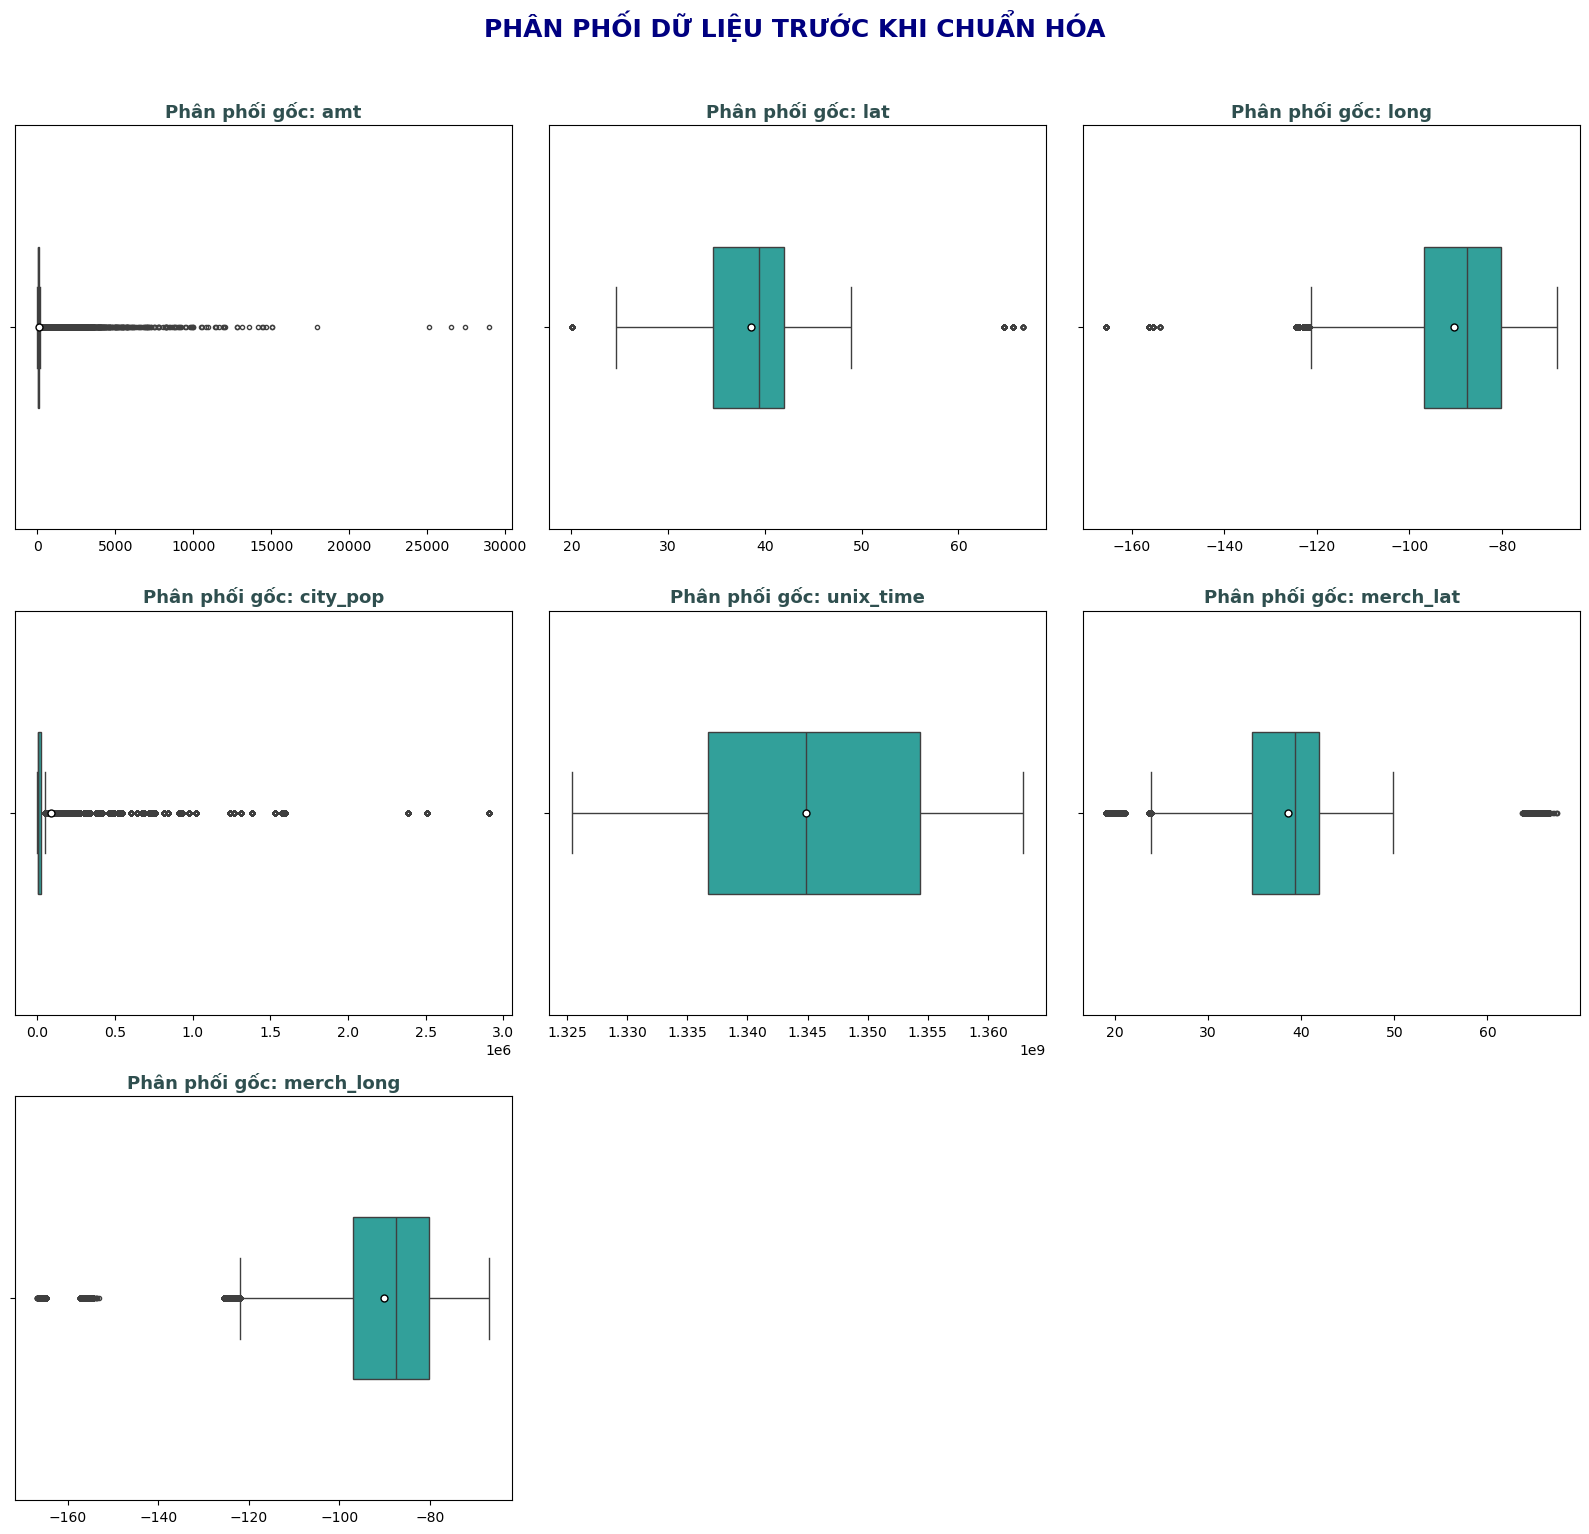

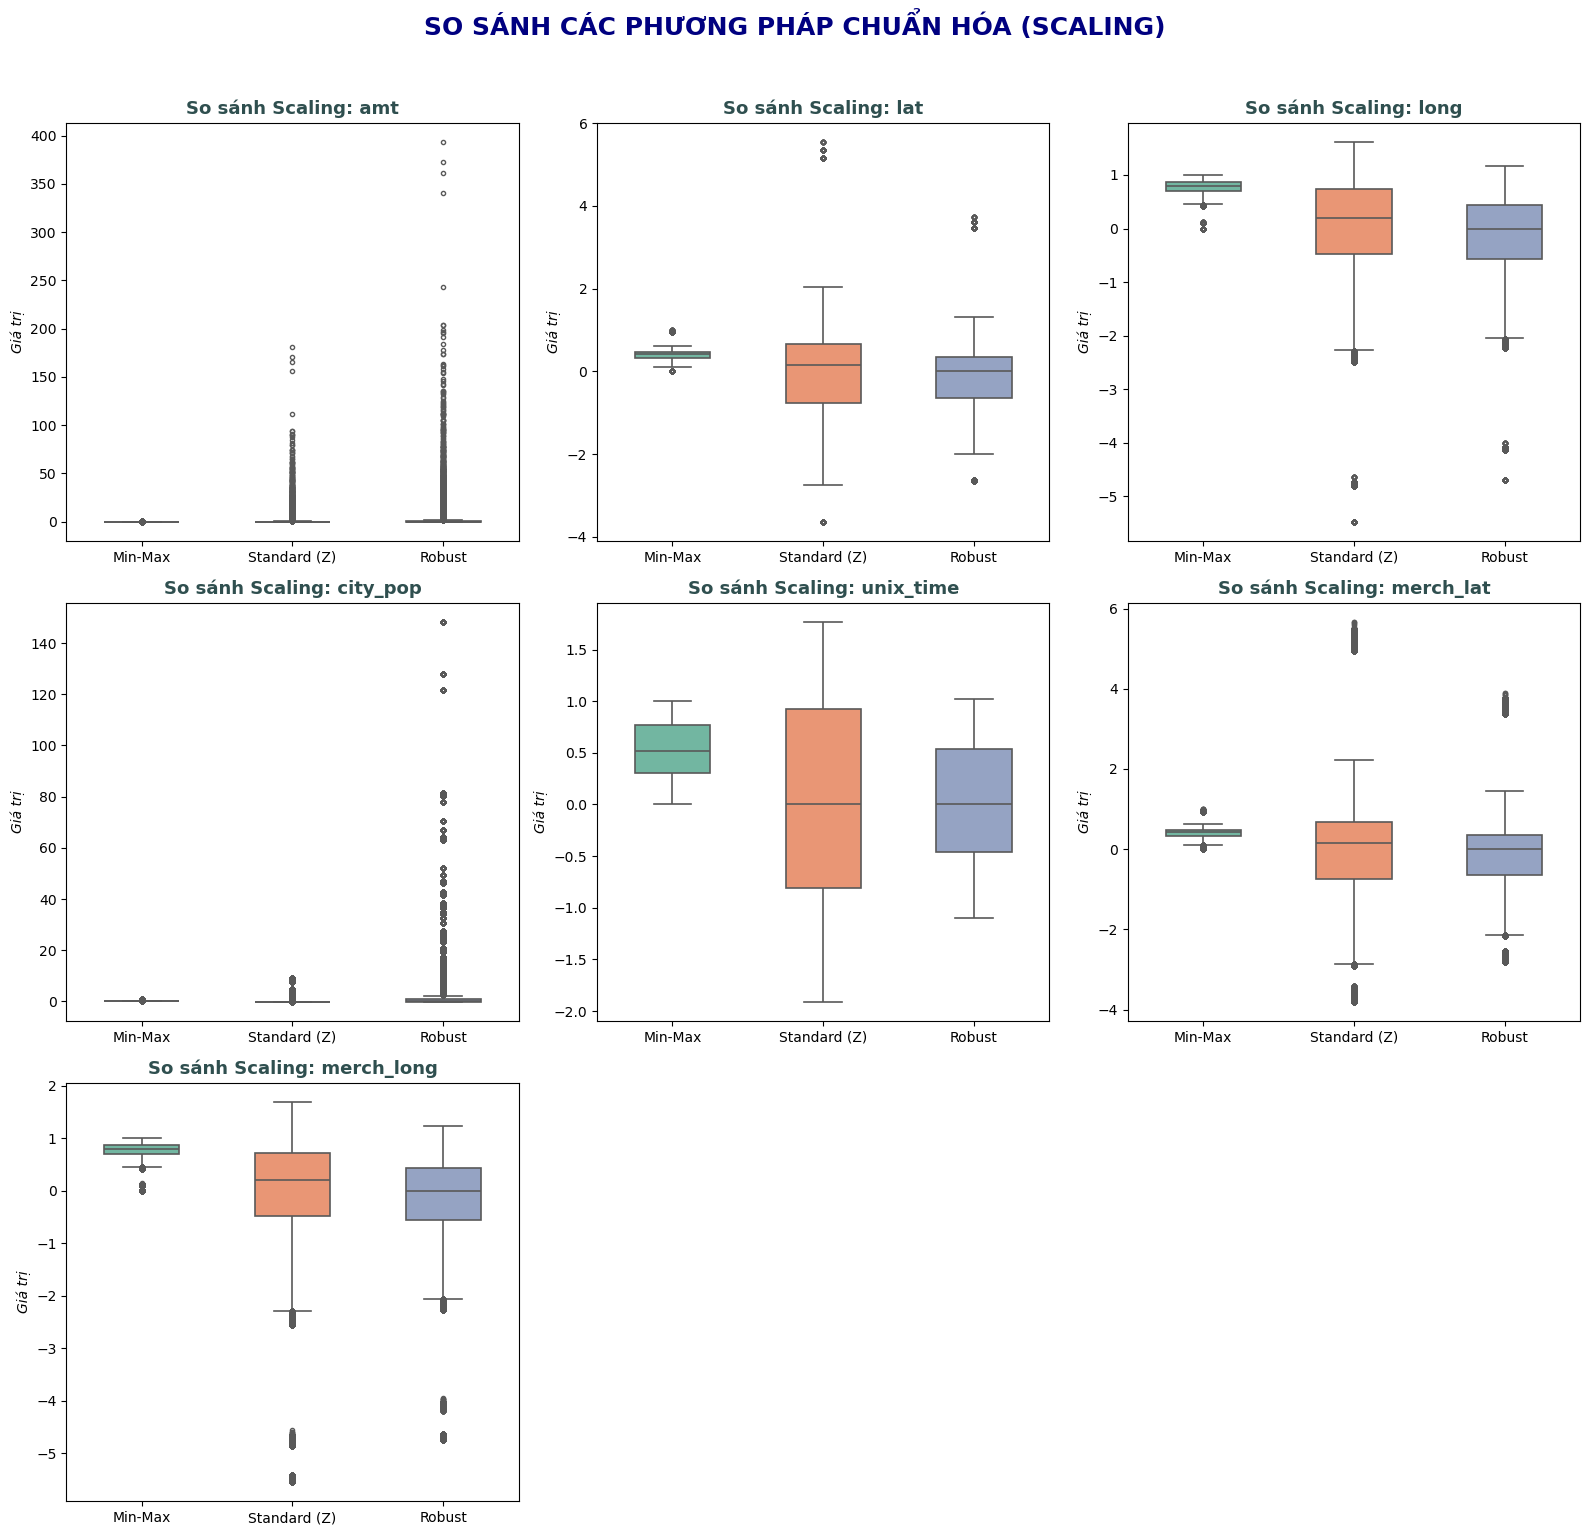

In [ ]:
# ==========================================
# Bước 3: Trực quan hóa kết quả (Histogram + KDE và Boxplot)
# ==========================================

n_features = len(num_cols)
n_cols_plot = 3
n_rows_plot = math.ceil(n_features / n_cols_plot)

plt.figure(figsize=(16, 5 * n_rows_plot))

for i, col in enumerate(num_cols):
    ax = plt.subplot(n_rows_plot, n_cols_plot, i + 1)
    sns.boxplot(
        x=dataTrain[col], ax=ax, 
        color='lightseagreen', width=0.4, 
        fliersize=3, 
        showmeans=True, 
        meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}
    )
    
    ax.set_title(f'Phân phối gốc: {col}', fontsize=13, fontweight='bold', color='darkslategray')
    ax.set_xlabel('') #Ẩn tên trục X cho đỡ rối vì tiêu đề đã có
    
plt.suptitle('PHÂN PHỐI DỮ LIỆU TRƯỚC KHI CHUẨN HÓA', fontsize=18, fontweight='black', color='navy', y=1.02)
plt.tight_layout()
plt.show()
# ==========================================
plt.figure(figsize=(16, 5 * n_rows_plot))

for i, col in enumerate(num_cols):
    ax = plt.subplot(n_rows_plot, n_cols_plot, i + 1)
    
    temp_df = pd.DataFrame({
        'Min-Max': train_minmax[col],
        'Standard (Z)': train_standard[col],
        'Robust': train_robust[col]
    })
    
    sns.boxplot(
        data=temp_df, ax=ax, 
        palette='Set2', width=0.5, 
        linewidth=1.2, fliersize=3
    )
    
    ax.set_title(f'So sánh Scaling: {col}', fontsize=13, fontweight='bold', color='darkslategray')
    ax.set_ylabel('Giá trị', fontsize=10, fontstyle='italic')
    
plt.suptitle('SO SÁNH CÁC PHƯƠNG PHÁP CHUẨN HÓA (SCALING)', fontsize=18, fontweight='black', color='navy', y=1.02)
plt.tight_layout()
plt.show()

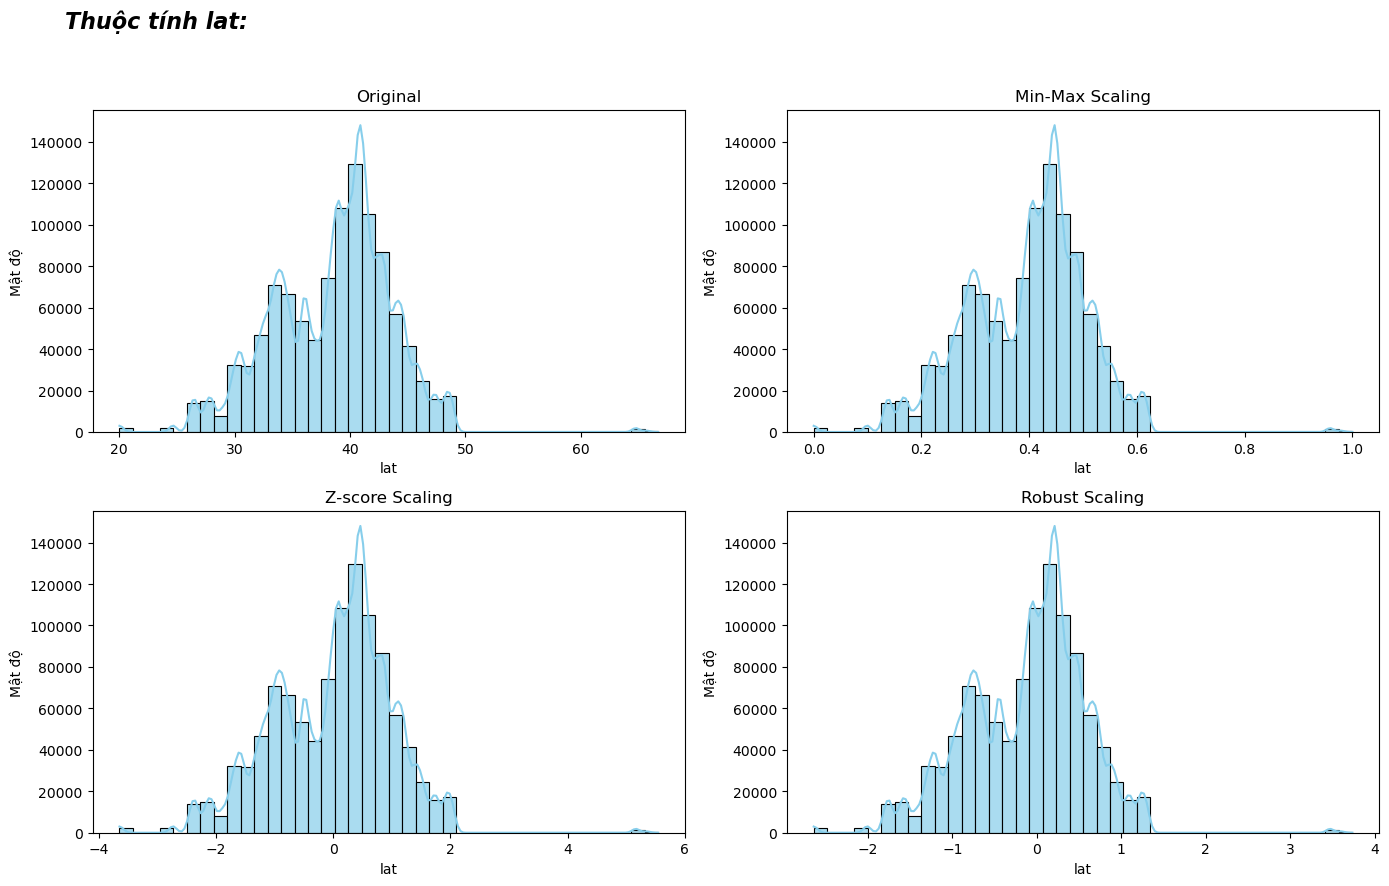

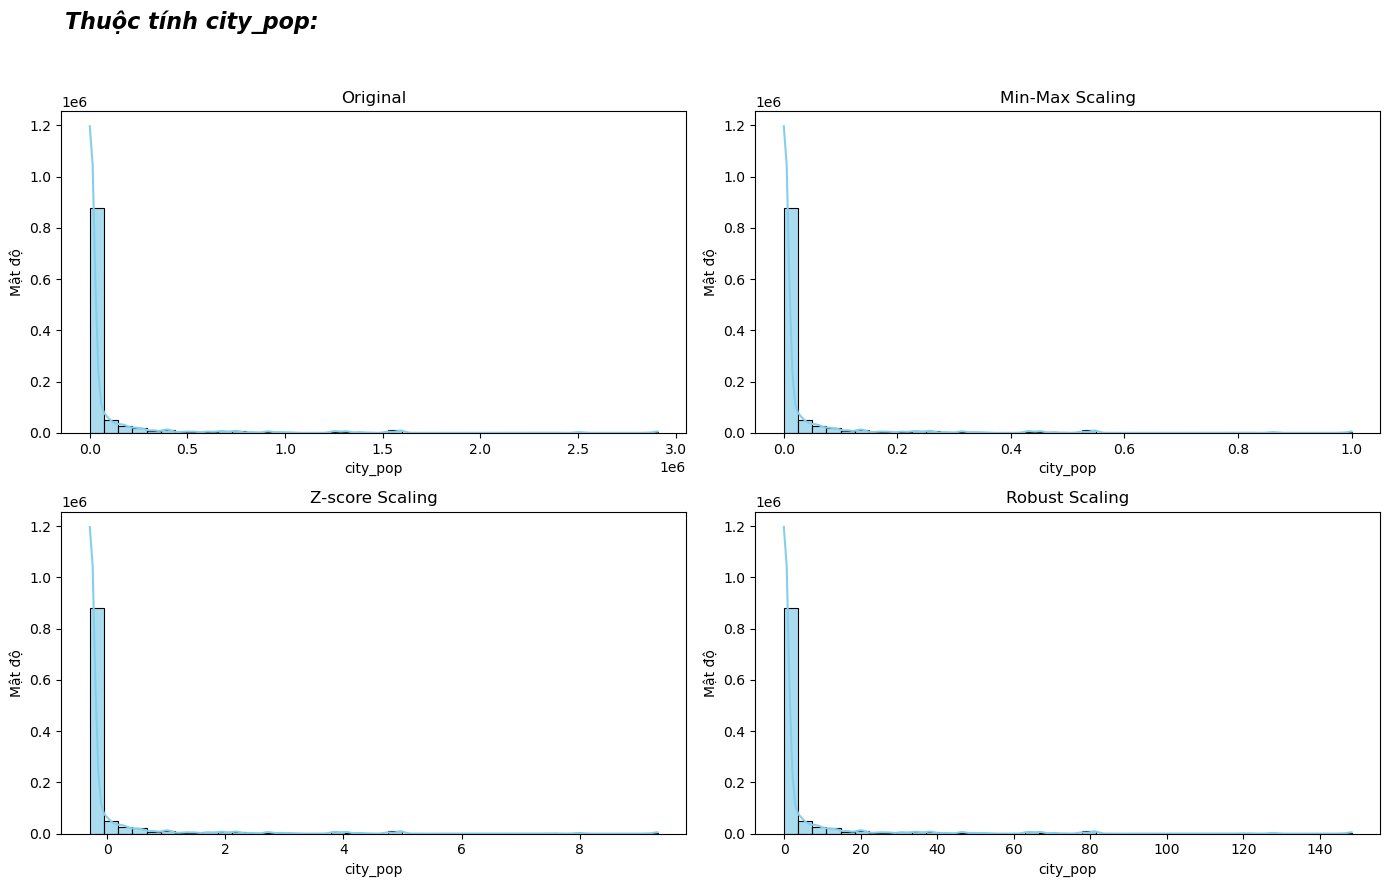

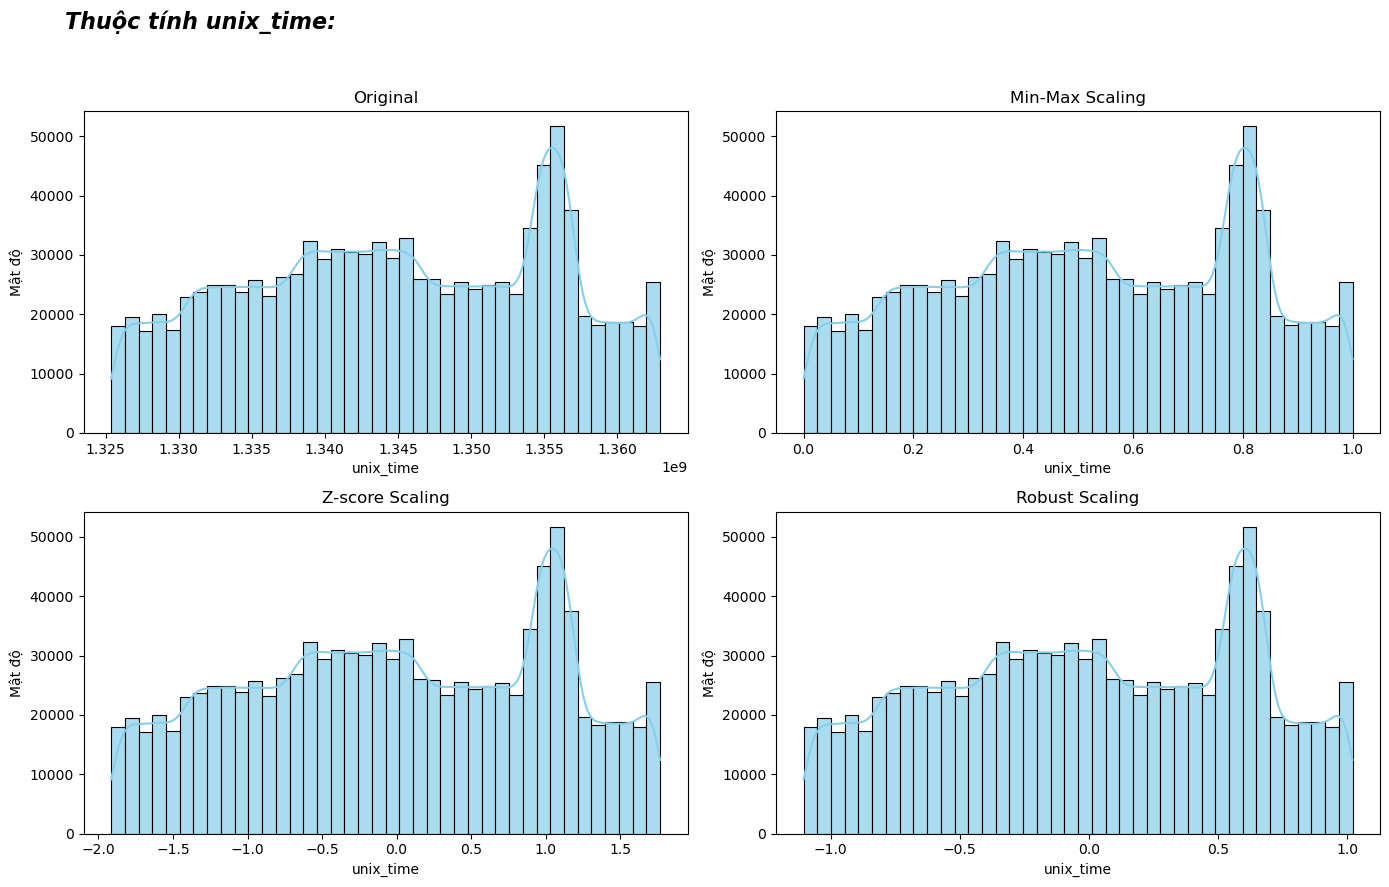

In [ ]:
# Chọn 3 thuộc tính tiêu biểu để trực quan hóa Histogram
selected_features = ['lat', 'city_pop', 'unix_time']

hist_kws = {
    'bins': 40,               # Số lượng cột
    'kde': True,              # Bật đường cong mật độ
    'color': 'skyblue',       # Màu xanh nhạt giống mẫu
    'edgecolor': 'black',     # Viền cột màu đen
    'alpha': 0.7              # Độ trong suốt
}

# Lặp qua từng thuộc tính để vẽ
for col in selected_features:
    # Bỏ qua nếu cột không tồn tại (đề phòng bạn đã drop trước đó)
    if col not in dataTrain.columns:
        continue
        
    # Tạo khung hình 2x2 cho mỗi thuộc tính
    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    
    # 1. Original Data (Góc trên trái)
    sns.histplot(dataTrain[col], ax=axes[0, 0], **hist_kws)
    axes[0, 0].set_title('Original', fontsize=12)
    axes[0, 0].set_ylabel('Mật độ')
    axes[0, 0].set_xlabel(col)
    
    # 2. Min-Max Scaling (Góc trên phải)
    sns.histplot(train_minmax[col], ax=axes[0, 1], **hist_kws)
    axes[0, 1].set_title('Min-Max Scaling', fontsize=12)
    axes[0, 1].set_ylabel('Mật độ')
    axes[0, 1].set_xlabel(col)
    
    # 3. Z-score Scaling (Góc dưới trái)
    sns.histplot(train_standard[col], ax=axes[1, 0], **hist_kws)
    axes[1, 0].set_title('Z-score Scaling', fontsize=12)
    axes[1, 0].set_ylabel('Mật độ')
    axes[1, 0].set_xlabel(col)
    
    # 4. Robust Scaling (Góc dưới phải)
    sns.histplot(train_robust[col], ax=axes[1, 1], **hist_kws)
    axes[1, 1].set_title('Robust Scaling', fontsize=12)
    axes[1, 1].set_ylabel('Mật độ')
    axes[1, 1].set_xlabel(col)
    
    plt.suptitle(f'Thuộc tính {col}:', fontsize=16, fontstyle='italic', fontweight='bold', ha='left', x=0.05, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
# ==========================================
# ÁP DỤNG ROBUST SCALING CHÍNH THỨC
# ==========================================

# Tạo bản copy dữ liệu gốc
dataTrain_scaled = dataTrain.copy()
dataTest_scaled  = dataTest.copy()

# Fit trên TRAIN
dataTrain_scaled[num_cols] = robust_scaler.fit_transform(dataTrain[num_cols])

# Transform trên TEST (KHÔNG fit lại)
dataTest_scaled[num_cols] = robust_scaler.transform(dataTest[num_cols])

In [6]:
print(dataTrain_scaled[num_cols].describe())

                amt           lat          long      city_pop     unix_time  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   3.109807e-01 -1.121512e-01 -1.652257e-01  4.421841e+00  2.438284e-04   
std    2.178884e+00  6.935685e-01  8.268379e-01  1.544218e+01  5.766339e-01   
min   -6.327476e-01 -2.640364e+00 -4.699243e+00 -1.242277e-01 -1.104155e+00   
25%   -5.150524e-01 -6.467028e-01 -5.601623e-01 -8.746490e-02 -4.647889e-01   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.849476e-01  3.532972e-01  4.398377e-01  9.125351e-01  5.352111e-01   
max    3.936991e+02  3.734887e+00  1.173474e+00  1.482892e+02  1.019597e+00   

          merch_lat    merch_long  
count  1.048575e+06  1.048575e+06  
mean  -1.147836e-01 -1.672381e-01  
std    7.072920e-01  8.262710e-01  
min   -2.813978e+00 -4.754008e+00  
25%   -6.411703e-01 -5.675752e-01  
50%    0.000000e+00  0.000000e+00  
75%    3.588297e-01  4.324248e-01  


## 3. Mã hóa thuộc tính phân loại - Categorical Encoding

In [7]:
import pandas as pd
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [8]:
dataTrain = dataTrain_scaled.copy()
dataTest  = dataTest_scaled.copy()

In [9]:
# 1. Label Encoding cho Gender (Dùng map tay cho nhanh và kiểm soát được)
dataTrain['gender'] = dataTrain['gender'].map({'M': 1, 'F': 0})
dataTest['gender'] = dataTest['gender'].map({'M': 1, 'F': 0})

# 2. One-Hot cho Category (Dùng pandas get_dummies hoặc Sklearn OneHotEncoder)
# Lưu ý: drop_first=True để tránh đa cộng tuyến
dataTrain = pd.get_dummies(dataTrain, columns=['category'], drop_first=True)
dataTest = pd.get_dummies(dataTest, columns=['category'], drop_first=True)

dataTrain, dataTest = dataTrain.align(dataTest, join='left', axis=1, fill_value=0)
# Cần đảm bảo 2 tập có cùng số cột sau khi get_dummies (align columns)

# 3. Target Encoding cho High Cardinality (VÍ DỤ QUAN TRỌNG)
high_card_cols = ['merchant', 'street', 'city', 'state', 'zip', 'job']

# Ép kiểu 'zip' sang string
dataTrain['zip'] = dataTrain['zip'].astype(str)
dataTest['zip'] = dataTest['zip'].astype(str)

In [10]:
# TARGET ENCODING
dataTrain_te = dataTrain.copy()
dataTest_te  = dataTest.copy()

# Khởi tạo Target Encoder
target_encoder = ce.TargetEncoder(
    cols=high_card_cols,
    smoothing=10
)

# Fit trên TRAIN
target_encoder.fit(
    dataTrain_te[high_card_cols],
    dataTrain_te['is_fraud']
)

# Transform trên TRAIN & TEST
dataTrain_te[high_card_cols] = target_encoder.transform(dataTrain_te[high_card_cols])
dataTest_te[high_card_cols]  = target_encoder.transform(dataTest_te[high_card_cols])

In [11]:
# FREQUENCY ENCODING
def frequency_encoding(train_df, test_df, cols):
    train_df = train_df.copy()
    test_df  = test_df.copy()
    
    for col in cols:
        freq = train_df[col].value_counts(normalize=True)
        train_df[col] = train_df[col].map(freq)
        test_df[col]  = test_df[col].map(freq).fillna(0)
    
    return train_df, test_df


dataTrain_fe, dataTest_fe = frequency_encoding(
    dataTrain,
    dataTest,
    high_card_cols
)

In [12]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, title=""):
    rf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f"\nKẾT QUẢ RANDOM FOREST – {title}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=6))


In [13]:
X_train_te = dataTrain_te.drop(columns=['is_fraud'])
y_train    = dataTrain_te['is_fraud']

X_test_te  = dataTest_te.drop(columns=['is_fraud'])
y_test     = dataTest_te['is_fraud']

train_and_evaluate_rf(
    X_train_te, y_train,
    X_test_te, y_test,
    title="Target Encoding"
)


KẾT QUẢ RANDOM FOREST – Target Encoding
Accuracy: 0.9961851223370084
              precision    recall  f1-score   support

           0   0.996192  0.999993  0.998089    553574
           1   0.878788  0.013520  0.026630      2145

    accuracy                       0.996185    555719
   macro avg   0.937490  0.506756  0.512359    555719
weighted avg   0.995739  0.996185  0.994339    555719



In [14]:
#=====================================================
X_train_fe = dataTrain_fe.drop(columns=['is_fraud'])
y_train    = dataTrain_fe['is_fraud']

X_test_fe  = dataTest_fe.drop(columns=['is_fraud'])
y_test     = dataTest_fe['is_fraud']

train_and_evaluate_rf(
    X_train_fe, y_train,
    X_test_fe, y_test,
    title="Frequency Encoding"
)


KẾT QUẢ RANDOM FOREST – Frequency Encoding
Accuracy: 0.9973619761066295
              precision    recall  f1-score   support

           0   0.997389  0.999969  0.998678    553574
           1   0.976157  0.324476  0.487054      2145

    accuracy                       0.997362    555719
   macro avg   0.986773  0.662222  0.742866    555719
weighted avg   0.997307  0.997362  0.996703    555719



## 4. Chọn lọc thuộc tính - Feature Selection

In [35]:
cols_to_drop = ['Unnamed: 0']

# chỉ xóa nếu tồn tại để tránh lỗi
dataTrain_fe = dataTrain_fe.drop(columns=[col for col in cols_to_drop if col in dataTrain_fe.columns])
dataTest_fe  = dataTest_fe.drop(columns=[col for col in cols_to_drop if col in dataTest_fe.columns])

In [36]:
# Feature Selection
X_train_full = dataTrain_fe.drop(columns=['is_fraud'])
y_train = dataTrain_fe['is_fraud']

X_test_full = dataTest_fe.drop(columns=['is_fraud'])
y_test = dataTest_fe['is_fraud']

In [37]:
# Chỉ giữ các cột số
# numeric_df = dataTrain_fe.select_dtypes(include=[np.number])

# 1. Tính ma trận tương quan đầy đủ
corr_matrix = dataTrain_fe.corr()

print("Ma trận tương quan:")
print(corr_matrix)

# ==========================================
# 2. Tính tương quan với target is_fraud
# ==========================================

target_corr = corr_matrix['is_fraud'].drop('is_fraud')

# Lấy trị tuyệt đối để đánh giá độ mạnh
target_corr_abs = target_corr.abs()

# Tạo bảng gồm:
# - tên feature
# - correlation gốc
# - correlation tuyệt đối
corr_ranking = pd.DataFrame({
    'Feature': target_corr.index,
    'Correlation': target_corr.values,
    'Absolute Correlation': target_corr_abs.values
})

# Sắp xếp giảm dần
corr_ranking = corr_ranking.sort_values(
    by='Absolute Correlation',
    ascending=False
).reset_index(drop=True)

# ==========================================
# 3. In TOP 10 kèm hệ số tương quan
# ==========================================

print("\nTOP 10 thuộc tính có tương quan mạnh nhất với is_fraud:")
print(corr_ranking.head(10))

# Nếu cần lưu danh sách feature
top10_corr_features = corr_ranking.head(10)['Feature'].tolist()

print("\nDanh sách TOP 10 features:")
print(top10_corr_features)

Ma trận tương quan:
                         merchant       amt    gender    street      city  \
merchant                 1.000000  0.010841 -0.004865 -0.019730 -0.015441   
amt                      0.010841  1.000000  0.001277 -0.009151 -0.007081   
gender                  -0.004865  0.001277  1.000000 -0.216846 -0.141016   
street                  -0.019730 -0.009151 -0.216846  1.000000  0.725934   
city                    -0.015441 -0.007081 -0.141016  0.725934  1.000000   
state                   -0.002118  0.006735 -0.028840 -0.000186  0.036378   
zip                     -0.019557 -0.008600 -0.202188  0.956411  0.760173   
lat                      0.005574 -0.001916  0.042635 -0.024489 -0.083262   
long                    -0.002247  0.000151  0.050314 -0.014530 -0.032119   
city_pop                -0.012609  0.006485 -0.028634  0.024541  0.276632   
job                     -0.003248 -0.005464 -0.096739  0.360889  0.272175   
unix_time               -0.000107 -0.001499 -0.001247  0

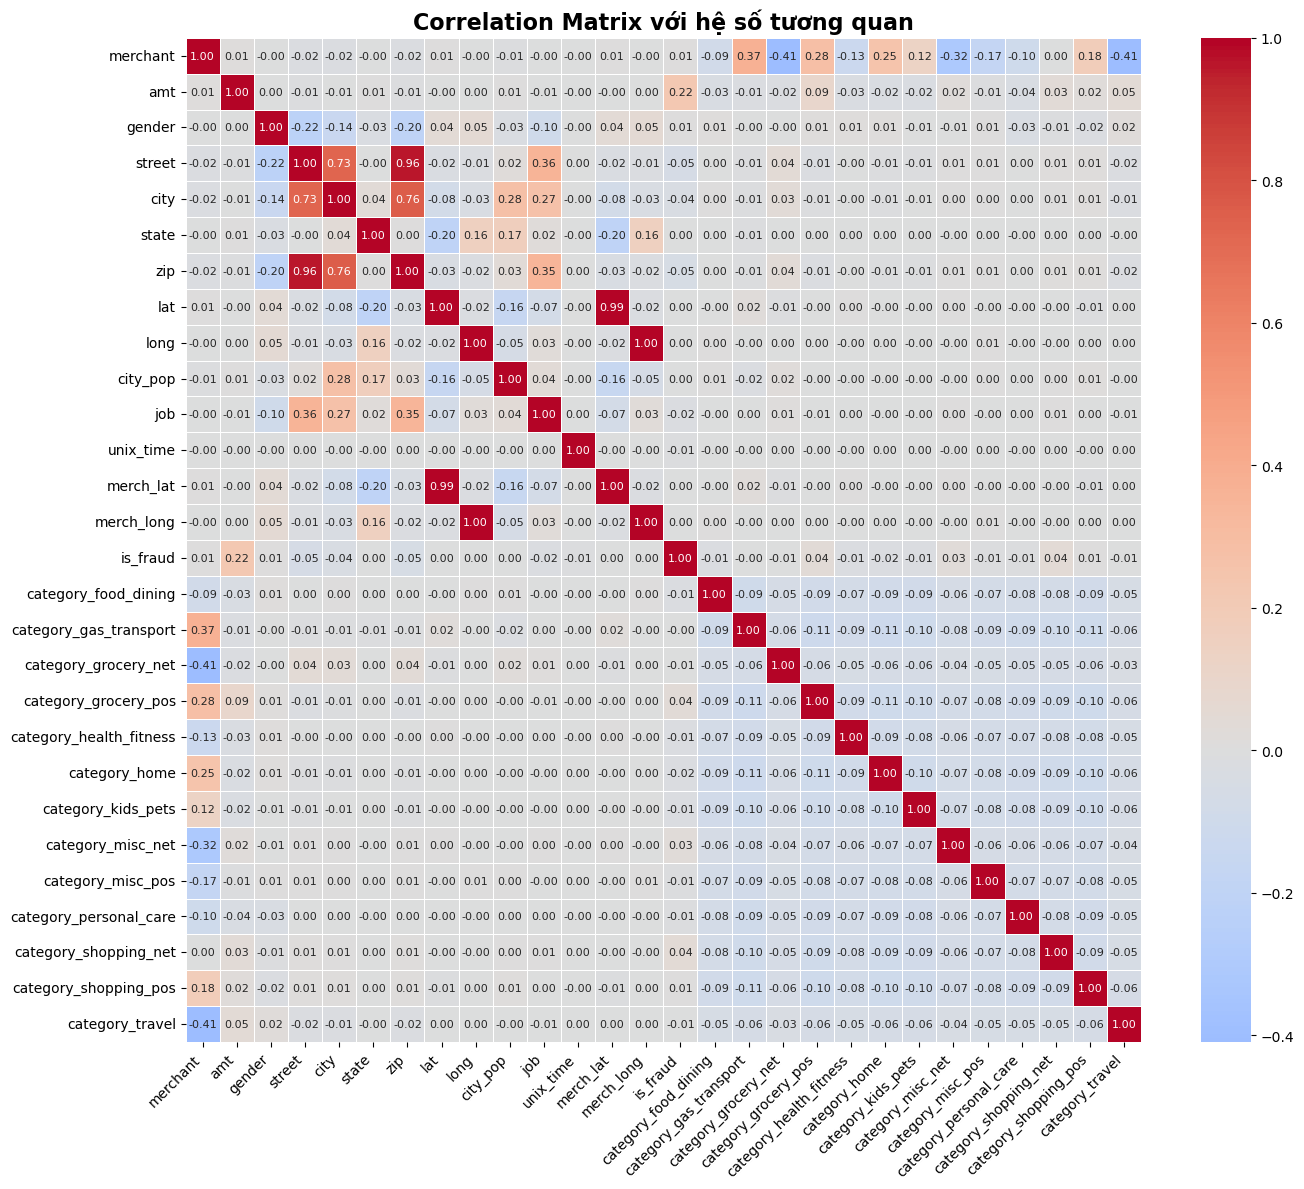

In [ ]:
# Vẽ heatmap ma trận tương quan

plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,       
    fmt=".2f",       
    annot_kws={"size": 8},  
    linewidths=0.5   
)

plt.title("Correlation Matrix với hệ số tương quan", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [39]:
X_train_corr = X_train_full[top10_corr_features]
X_test_corr = X_test_full[top10_corr_features]

In [40]:
# PP2: Tính Mutual Information giữa các feature và target
# Lấy sample để tăng tốc
sample_size = 100000

X_sample = X_train_full.sample(sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]

mi_scores = mutual_info_classif(
    X_sample,
    y_sample,
    discrete_features=False,
    random_state=42
)

# Chuyển thành Series
mi_series = pd.Series(mi_scores, index=X_train_full.columns)

# Sắp xếp giảm dần
mi_sorted = mi_series.sort_values(ascending=False)

# ==========================================
# Tạo bảng kết quả đầy đủ có thứ hạng
# ==========================================
mi_table = pd.DataFrame({
    'Rank': range(1, len(mi_sorted) + 1),
    'Feature': mi_sorted.index,
    'Mutual Information Score': mi_sorted.values
})

# Reset index cho đẹp
mi_table = mi_table.reset_index(drop=True)

# In toàn bộ bảng
print("\nBảng xếp hạng Mutual Information:")
print(mi_table)
top10_mi_features = mi_table.head(10)['Feature'].tolist()
# ==========================================
# Nếu chỉ muốn lấy Top 10 để đưa vào báo cáo
# ==========================================
mi_top10_table = mi_table.head(10)

print("\nTop 10 thuộc tính theo Mutual Information:")
print(mi_top10_table)


Bảng xếp hạng Mutual Information:
    Rank                  Feature  Mutual Information Score
0      1                      amt                  0.015946
1      2                   gender                  0.012770
2      3                   street                  0.003927
3      4                      zip                  0.003720
4      5                     city                  0.003105
5      6                unix_time                  0.002241
6      7                      job                  0.002127
7      8                 city_pop                  0.001711
8      9                     long                  0.001634
9     10                 merchant                  0.001513
10    11                      lat                  0.001399
11    12    category_shopping_net                  0.001009
12    13     category_grocery_pos                  0.000907
13    14                    state                  0.000822
14    15            category_home                  0.000748
15   

In [41]:
X_train_mi = X_train_full[top10_mi_features]
X_test_mi = X_test_full[top10_mi_features]

In [42]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, title=""):

    rf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    print(f"\n========== RANDOM FOREST – {title} ==========")

    print("Accuracy:", accuracy_score(y_test, y_pred))

    print(classification_report(
        y_test,
        y_pred,
        digits=6
    ))

In [43]:
train_and_evaluate_rf(
    X_train_corr,
    y_train,
    X_test_corr,
    y_test,
    title="Top 10 Features (Correlation)"
)


========== RANDOM FOREST – Top 10 Features (Correlation) ==========
Accuracy: 0.9966079979270098
              precision    recall  f1-score   support

           0   0.997892  0.998705  0.998298    553574
           1   0.576741  0.455478  0.508987      2145

    accuracy                       0.996608    555719
   macro avg   0.787317  0.727091  0.753642    555719
weighted avg   0.996266  0.996608  0.996409    555719



In [45]:
train_and_evaluate_rf(
    X_train_mi,
    y_train,
    X_test_mi,
    y_test,
    title="Top 10 Features (Mutual Information)"
)


========== RANDOM FOREST – Top 10 Features (Mutual Information) ==========
Accuracy: 0.9964406471616051
              precision    recall  f1-score   support

           0   0.996450  0.999989  0.998217    553574
           1   0.966480  0.080653  0.148881      2145

    accuracy                       0.996441    555719
   macro avg   0.981465  0.540321  0.573549    555719
weighted avg   0.996335  0.996441  0.994938    555719

